In [40]:
%pip install seaborn

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [42]:
stats = pd.read_csv('vk-t20.csv', index_col=0)
stats['Start Date'] = pd.to_datetime(stats['Start Date'])
stats = stats.sort_values('Start Date')
stats.head()

,Runs,Balls Faced,Fours,Sixes,Strike Rate,Position,Dismissal,Inns,Format,Opposition,Venue,Start Date,Location
1,26,21,3,1,123.80,5,not out,2,T20I,Zimbabwe,Harare,2010-06-12,Away
2,28,19,5,0,147.36,1,bowled,1,T20I,South Africa,Durban,2011-01-09,Away
3,14,12,2,0,116.66,3,caught,1,T20I,West Indies,Port of Spain,2011-06-04,Away
4,4,5,0,0,80.00,4,caught,1,T20I,England,Manchester,2011-08-31,Away
5,15,16,3,0,93.75,3,caught,1,T20I,England,Eden Gardens,2011-10-29,Home


In [43]:
stats['RA_Runs'] = stats['Runs'].rolling(window=5, min_periods=1, closed='left').mean()
stats['RA_Fours'] = stats['Fours'].rolling(window=5, min_periods=1, closed='left').mean()
stats['RA_Sixes'] = stats['Sixes'].rolling(window=5, min_periods=1, closed='left').mean()
stats['RA_StrikeRate'] = stats['Strike Rate'].rolling(window=5, min_periods=1, closed='left').mean()

#Encoding Categorical Variables
le_opp = LabelEncoder()
stats['ENC_Opposition'] = le_opp.fit_transform(stats['Opposition'])

le_loc = LabelEncoder()
stats['ENC_Location'] = le_loc.fit_transform(stats['Location'])

stats.fillna(0, inplace=True) #ensuring no NaN values

In [44]:
stats.head(15)

,Runs,Balls Faced,Fours,Sixes,Strike Rate,Position,Dismissal,Inns,Format,Opposition,Venue,Start Date,Location,RA_Runs,RA_Fours,RA_Sixes,RA_StrikeRate,ENC_Opposition,ENC_Location
1,26,21,3,1,123.80,5,not out,2,T20I,Zimbabwe,Harare,2010-06-12,Away,0.000000,0.000000,0.000000,0.000000,14,0
2,28,19,5,0,147.36,1,bowled,1,T20I,South Africa,Durban,2011-01-09,Away,26.000000,3.000000,1.000000,123.800000,10,0
3,14,12,2,0,116.66,3,caught,1,T20I,West Indies,Port of Spain,2011-06-04,Away,27.000000,4.000000,0.500000,135.580000,13,0
4,4,5,0,0,80.00,4,caught,1,T20I,England,Manchester,2011-08-31,Away,22.666667,3.333333,0.333333,129.273333,3,0
5,15,16,3,0,93.75,3,caught,1,T20I,England,Eden Gardens,2011-10-29,Home,18.000000,2.500000,0.250000,116.955000,3,1
6,22,21,0,1,104.76,3,caught,2,T20I,Australia,Sydney,2012-02-01,Away,17.400000,2.600000,0.200000,112.314000,1,0
7,31,24,3,0,129.16,3,caught,2,T20I,Australia,Melbourne,2012-02-03,Away,16.600000,2.000000,0.200000,108.506000,1,0
8,68,48,11,1,141.66,3,caught,1,T20I,Sri Lanka,Pallekele,2012-08-07,Away,17.200000,1.600000,0.200000,104.866000,11,0
9,70,41,10,1,170.73,2,caught,2,T20I,New Zealand,Chennai,2012-09-11,Home,28.000000,3.400000,0.400000,109.866000,7,1
10,50,39,4,2,128.20,3,caught,1,T20I,Afghanistan,Colombo (RPS),2012-09-19,Away,41.200000,5.400000,0.600000,128.012000,0,0


In [45]:
#Features
features = ['RA_Runs', 'RA_Fours', 'RA_Sixes', 'RA_StrikeRate', 'ENC_Opposition', 'ENC_Location', 'Position']
predictors = stats[features]
target = stats['Runs']

In [46]:
#splitting data in chronological order, so the model does not predict past data which could happen when using train_test_split
train_size = int(0.8 * len(stats))
x_train = predictors[:train_size]
y_train = target[:train_size]
x_test = predictors[train_size:]
y_test = target[train_size:]

In [47]:
def evaluate_model(model, actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = float(np.sqrt(mse))
    r2 = r2_score(actual, predicted)

    print(f"Model: {model}")
    print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2: {r2}")

In [48]:
#Finding Optimal Parameters for RandomForestRegressor Model
rfr = RandomForestRegressor(random_state=42)
rf_params = {'n_estimators': [100, 200, 300], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_depth': [6, 8, 10]}
rf_grid = GridSearchCV(estimator=rfr, param_grid=rf_params, cv=5, n_jobs=-1)
rf_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]})

In [49]:
print(f"RandomForestRegressor Best Parameters: {rf_grid.best_params_}")

RandomForestRegressor Best Parameters: {'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


In [50]:
#Finding Optimal Parameters for XGBoost Regressor Model
best_score = float("inf")
best_params = None

xgb_params = {"max_depth": [3, 5, 7], "learning_rate": [0.01, 0.05, 0.1], "n_estimators": [100, 300, 500], "subsample": [0.8, 0.9, 1.0], "colsample_bytree": [0.8, 0.9, 1.0]}

for md in xgb_params["max_depth"]:
    for lr in xgb_params["learning_rate"]:
        for ne in xgb_params["n_estimators"]:
            for ss in xgb_params["subsample"]:
                for cs in xgb_params["colsample_bytree"]:
                    xgb_model = XGBRegressor(max_depth=md, learning_rate=lr, n_estimators=ne, subsample=ss, colsample_bytree=cs, random_state=42)
                    xgb_model.fit(x_train, y_train)
                    xgb_preds = xgb_model.predict(x_test)
                    rmse = np.sqrt(mean_squared_error(y_test,  xgb_preds))
    
                    if rmse < best_score:
                        best_score = rmse
                        best_params = [md, lr, ne, ss, cs]

print("Best RMSE:", best_score)
print("Best Params:", best_params)

Best RMSE: 31.552370164351856
Best Params: [3, 0.05, 500, 1.0, 0.8]


In [51]:
#Linear Regression Model
pipe = Pipeline([('scale', StandardScaler()), ('model', LinearRegression())])
pipe.fit(x_train, y_train)
lin_ypreds = pipe.predict(x_test)

In [57]:
#RandomForestRegressor Model
rfr = RandomForestRegressor(n_estimators=100, max_depth=8, min_samples_split=10, min_samples_leaf=4, random_state=42)
rfr.fit(x_train, y_train)
rfr_ypreds = rfr.predict(x_test)

In [58]:
#XGBoost Regression Model
xgb = XGBRegressor(n_estimators=500, max_depth=3, learning_rate=0.05, subsample=1, colsample_bytree=0.8, random_state=42)
xgb.fit(x_train, y_train)
xgb_ypreds = xgb.predict(x_test)

In [59]:
#Getting Results and Scores for Models
evaluate_model("Linear Regression", y_test, lin_ypreds)
evaluate_model("RandomForestRegressor", y_test, rfr_ypreds)
evaluate_model("XGBoost Regressor", y_test, xgb_ypreds)

Model: Linear Regression
MAE: 30.654494153930234, MSE: 1175.3767601706413, RMSE: 34.28376817344677, R2: -0.08955185276821198
Model: RandomForestRegressor
MAE: 28.372603737452277, MSE: 1122.033141535244, RMSE: 33.4967631501201, R2: -0.04010333507834374
Model: XGBoost Regressor
MAE: 26.511459350585938, MSE: 995.5520629882812, RMSE: 31.552370164351856, R2: 0.07714217901229858


Text(0.5, 1.0, 'XGBoost Regression: Predicted vs. Actual Runs')

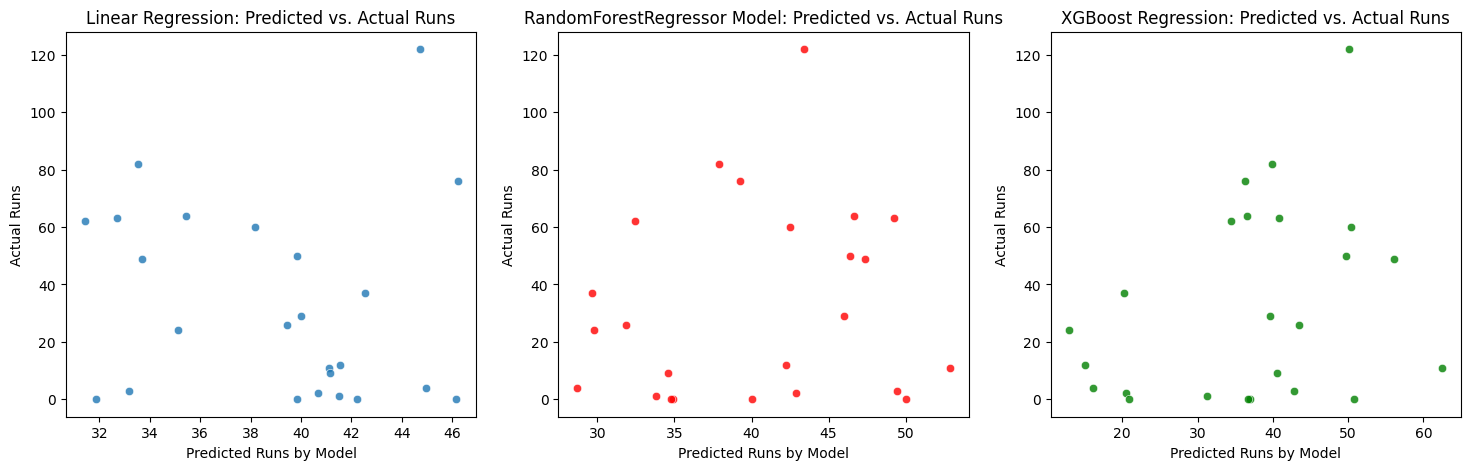

In [60]:
#Visualizations of Predicted vs. Actual
plt.figure(figsize=(18,5))

#Linear Regression
plt.subplot(1,3,1)
sns.scatterplot(x=lin_ypreds, y=y_test, alpha=0.8) 
plt.xlabel("Predicted Runs by Model")
plt.ylabel("Actual Runs")
plt.title("Linear Regression: Predicted vs. Actual Runs")

plt.subplot(1,3,2)
sns.scatterplot(x=rfr_ypreds, y=y_test, alpha=0.8, color="red") 
plt.xlabel("Predicted Runs by Model")
plt.ylabel("Actual Runs")
plt.title("RandomForestRegressor Model: Predicted vs. Actual Runs")

plt.subplot(1,3,3)
sns.scatterplot(x=xgb_ypreds, y=y_test, alpha=0.8, color="green") 
plt.xlabel("Predicted Runs by Model")
plt.ylabel("Actual Runs")
plt.title("XGBoost Regression: Predicted vs. Actual Runs")

Text(0.5, 1.0, 'XGBoost Regression: Feature Importance')

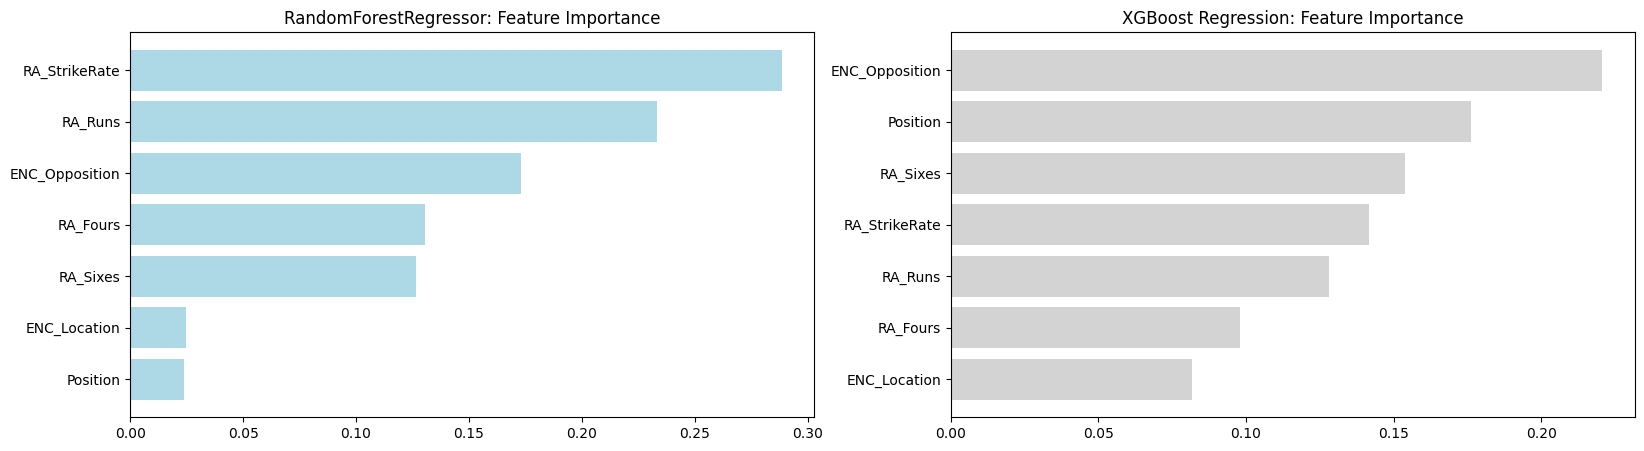

In [61]:
#Feature Importances for RandomForestRegressor and XGBoost
features = ['RA_Runs', 'RA_Fours', 'RA_Sixes', 'RA_StrikeRate', 'ENC_Opposition', 'ENC_Location', 'Position']
plt.figure(figsize=(30,5))

#RandomForestRegressor
rfr_df = pd.DataFrame({'Feature': features, 'Importance': rfr.feature_importances_}).sort_values(by='Importance', ascending=True)
plt.subplot(1,3,1)
plt.barh(rfr_df['Feature'], rfr_df['Importance'], color='lightblue')
plt.title("RandomForestRegressor: Feature Importance")

#XGBoost
xgb_df = pd.DataFrame({'Feature': features, 'Importance': xgb.feature_importances_}).sort_values(by='Importance', ascending=True)
plt.subplot(1,3,2)
plt.barh(xgb_df['Feature'], xgb_df['Importance'], color='lightgrey')
plt.title("XGBoost Regression: Feature Importance")